# Setup

In [21]:
import pandas as pd
import numpy as np

import os
import glob
import requests

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gp

from zipfile import ZipFile
import urllib.request
from os import path
import plotly.graph_objs as go
# Import us state abbreviation dict
%run ../notebooks/scripts/us_state_abbrev.py

In [ ]:
# Preprocessing the data
statesDataProcessingPath = glob.glob('../notebooks/scripts/states/*')
for processingPath in statesDataProcessingPath:
    %run $processingPath

## Import the preprocessed dataframes

In [ ]:
#Note: If you do not have the preprocessed files in the ../data/processed directory things will not work and some states will be missing.
# If the above script fails because the state health department has changed the files please download https://falconbgsu-my.sharepoint.com/:u:/g/personal/vvela_bgsu_edu/ES3bHiPtUL5EtFizS55GnLcByWq6LH_4Pa9FAgR1P7HZpQ?e=DD5VU2

byCountyDf = pd.concat(map(pd.read_csv,  glob.glob('../data/processed/by_county/*')))
byStateDf = pd.concat(map(pd.read_csv,  glob.glob('../data/processed/by_state/*')))

In [ ]:
# CDC Death data
excessCdcDeathsDf = pd.read_csv("https://data.cdc.gov/api/views/muzy-jte6/rows.csv?accessType=DOWNLOAD")

# tests from https://covidtracking.com/data
df_tracker = pd.read_csv("https://covidtracking.com/data/download/all-states-history.csv")

## Import GeoJSON files

In [ ]:
zipPath = "../data/raw/topojson-master.zip"
if not path.exists(zipPath):
    url = "https://github.com/deldersveld/topojson/archive/master.zip"
    exportIntermediatePath = '../data/raw/'
    urllib.request.urlretrieve(url, zipPath)
    with ZipFile(zipPath, 'r') as zippedFile:
        zippedFile.extractall(exportIntermediatePath)

## Setup data types for dataframes

In [ ]:
byCountyDf['Date']       = pd.to_datetime(byCountyDf['Date'])
byCountyDf['State']      = byCountyDf['State'].astype('category')
byCountyDf['County']     = byCountyDf['County'].astype('category')
byCountyDf["WeekNumber"] = byCountyDf["Date"].dt.isocalendar().week

byStateDf['Date']        = pd.to_datetime(byStateDf['Date'])
byStateDf['State']       = byStateDf['State'].astype('category')
byStateDf["WeekNumber"]  = byStateDf["Date"].dt.isocalendar().week
byStateDf["Tests"]       = byStateDf["Positive"] + byStateDf["Negative"]

excessCdcDeathsDf["Week Ending Date"] = pd.to_datetime( excessCdcDeathsDf["Week Ending Date"])
excessCdcDeathsDf["WeekNumber"] = excessCdcDeathsDf["Week Ending Date"].dt.isocalendar().week

df_tracker["date"] = pd.to_datetime(df_tracker["date"])
df_tracker["WeekNumber"] = df_tracker["date"].dt.isocalendar().week

## Additional setups

In [ ]:
states = { state: us_state_abbrev[state] for state in byStateDf['State'].unique() }
states

# Analysis

## GeoJSON

In [22]:
# Get the right states from https://github.com/deldersveld/topojson/tree/master/countries/us-states

geoJsonPaths = {}
for st in states.values():
    geoJsonPaths[st] = glob.glob('../data/raw/topojson-master/countries/us-states/' + st + "*")

In [23]:
def plot_map(state, case_type, ax=None, names = False):
    if not ax:
        ax = plt.gca()
    st = states[state]
    geoDataFrame = gp.read_file(geoJsonPaths[st][0], ax=ax)
    countyDataFrame = byCountyDf[byCountyDf["State"] == state].groupby(["County"]).sum()
    geoDataFrameMerged = geoDataFrame.merge(countyDataFrame, right_on="County", left_on="NAME")
    geoDataFrameMerged["center"] = geoDataFrameMerged["geometry"].centroid
    countyNames = geoDataFrameMerged.copy()
    countyNames.set_geometry("center", inplace=True)

    # Plot cases
    geoDataFrameMerged.plot(column=case_type, legend=True, figsize=(15,10), cmap='YlOrRd', ax=ax)
    if names:
        for x, y, label in zip(countyNames.geometry.x, countyNames.geometry.y, countyNames["NAME"]):
            ax.text(x, y, label, fontsize = 10)
    ax.set_title(state+': ' + case_type + ' heatmap')
   

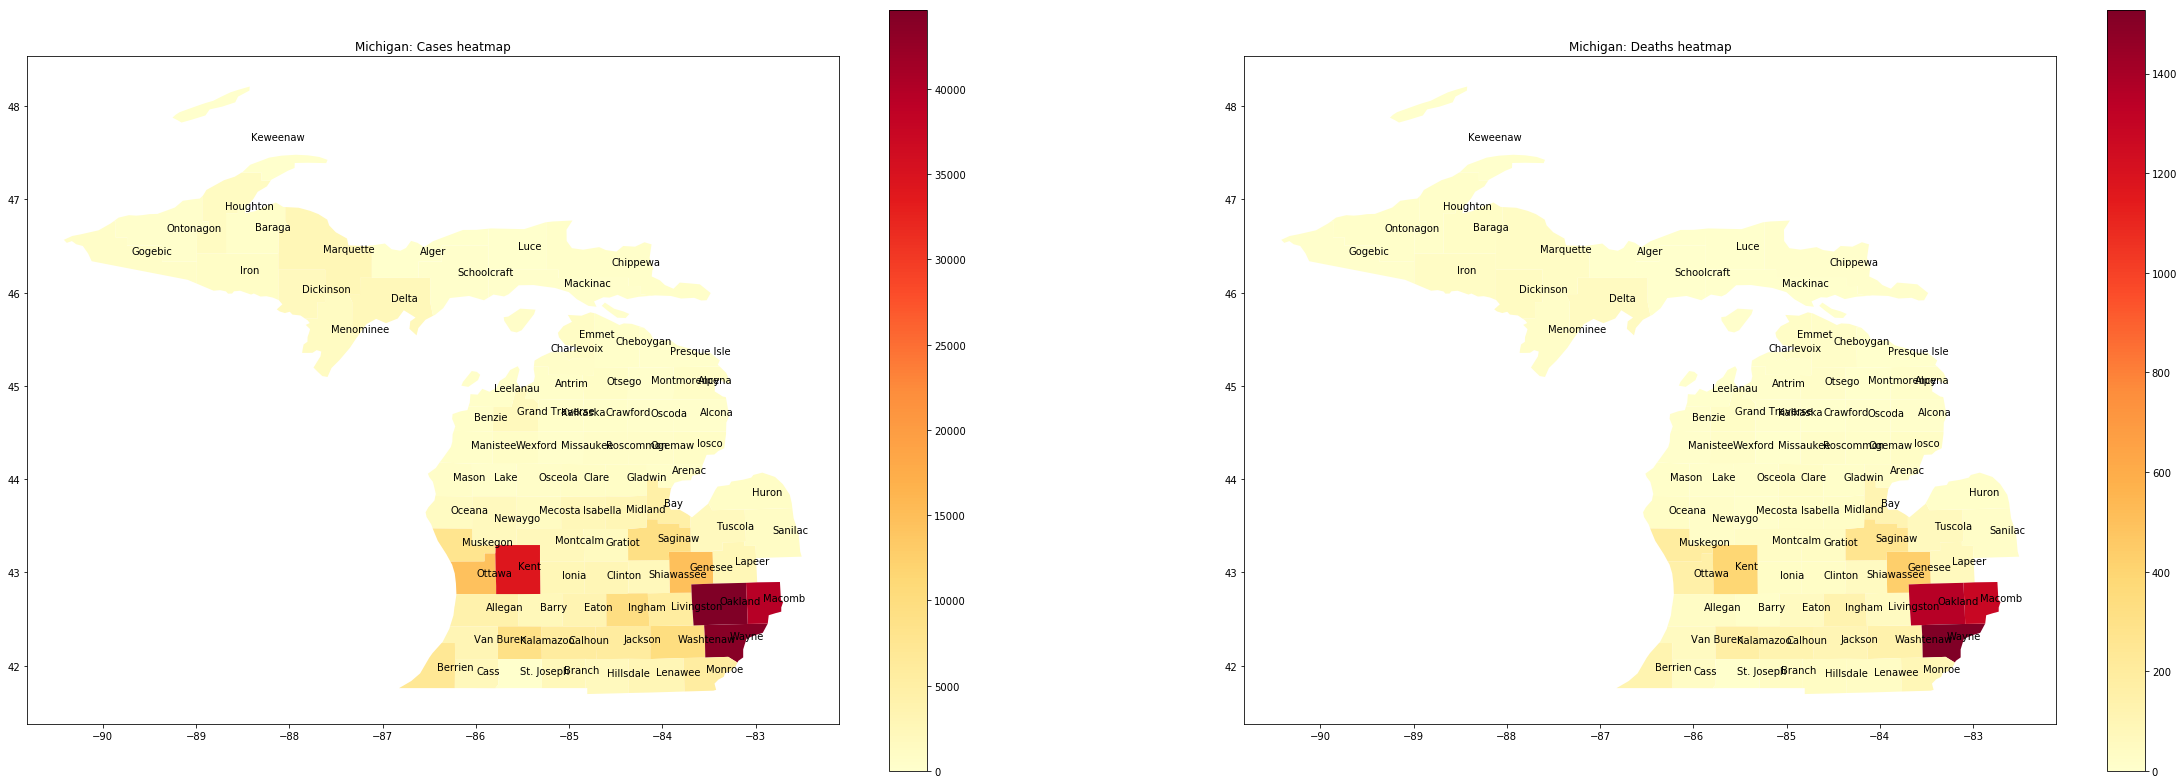

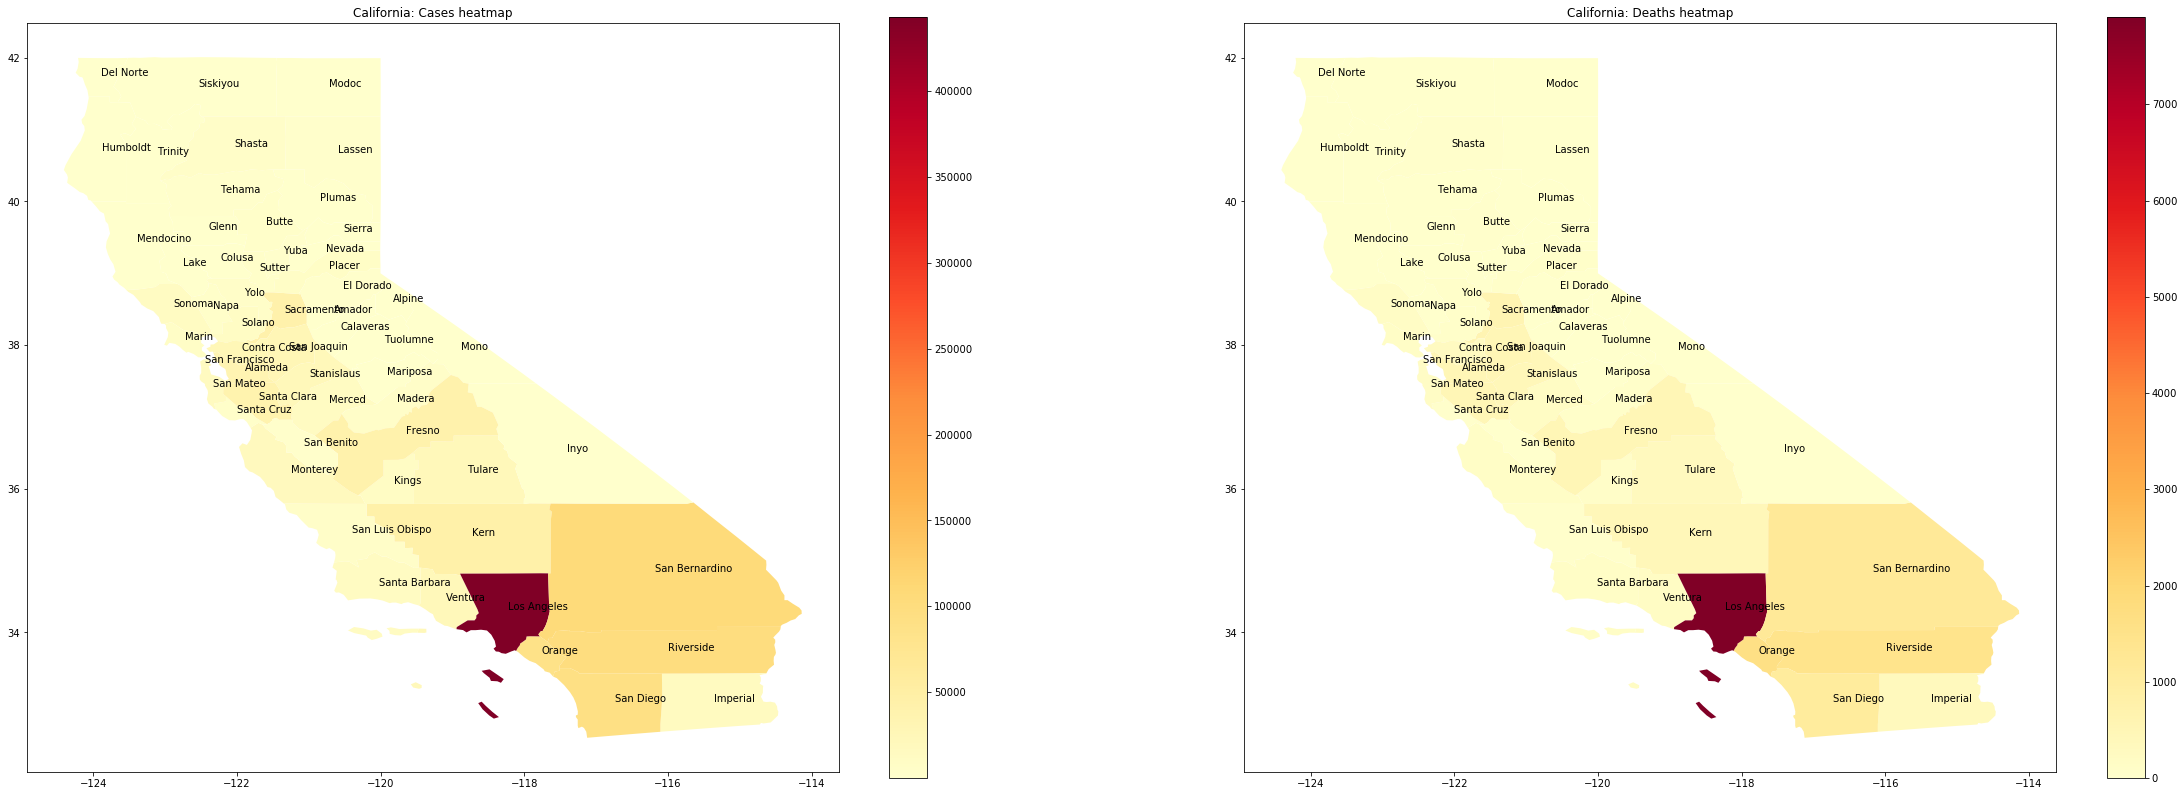

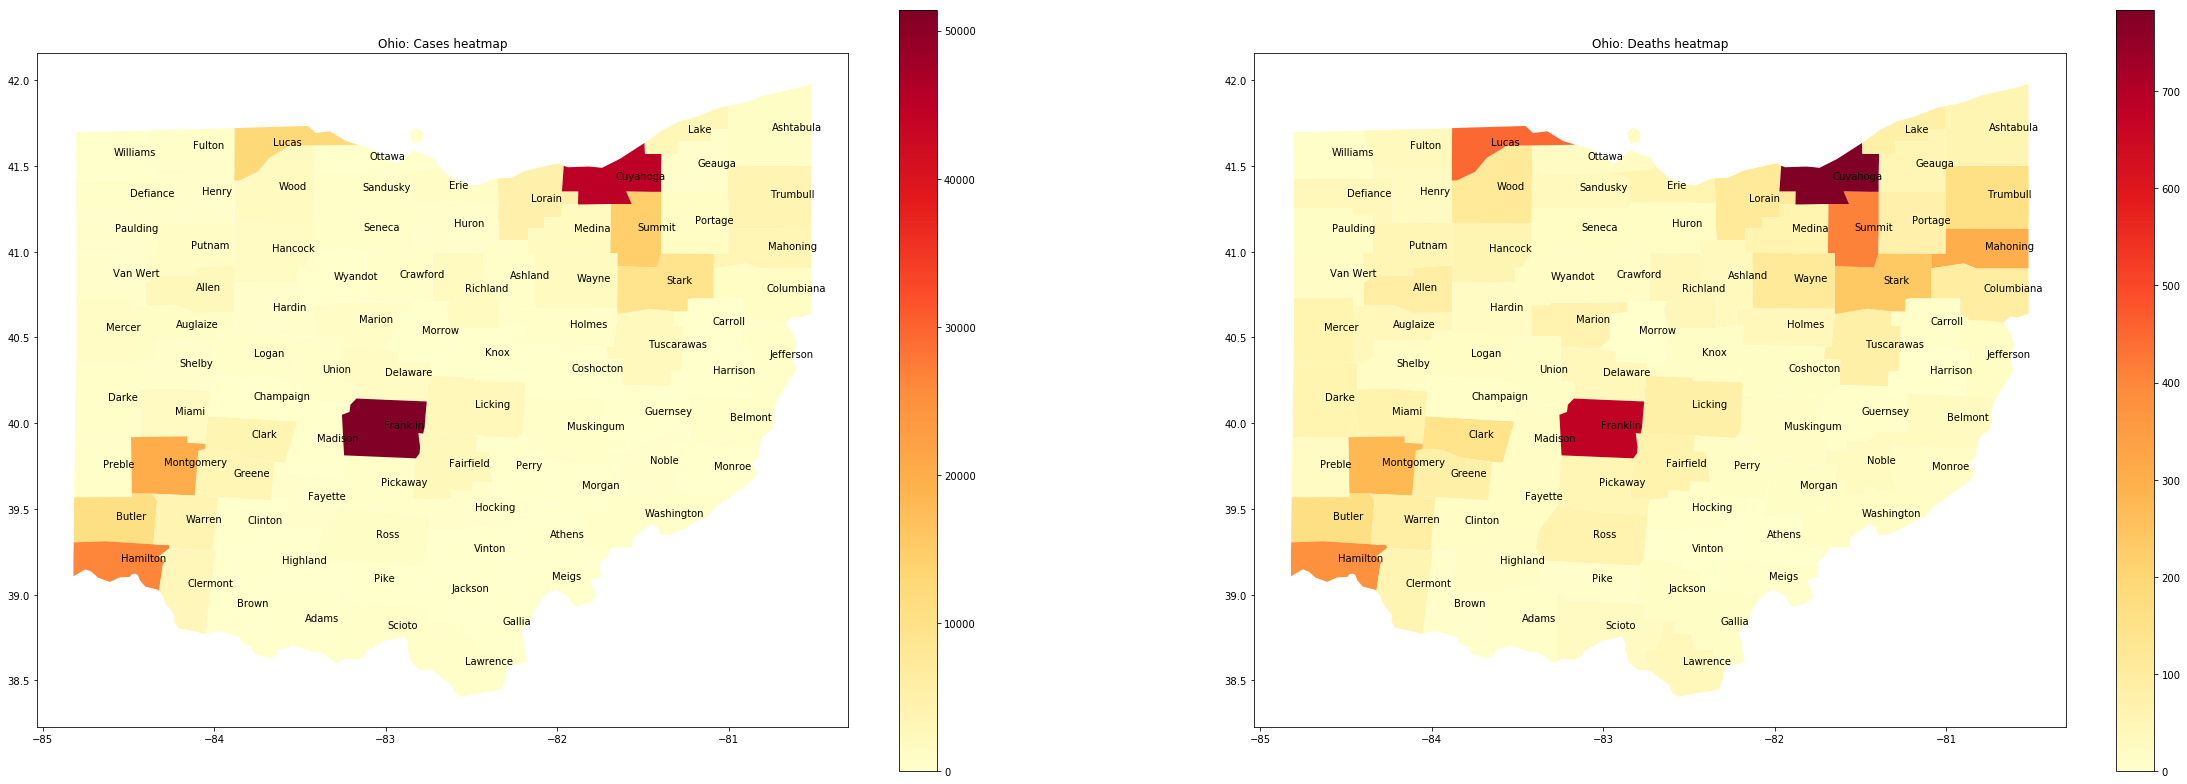

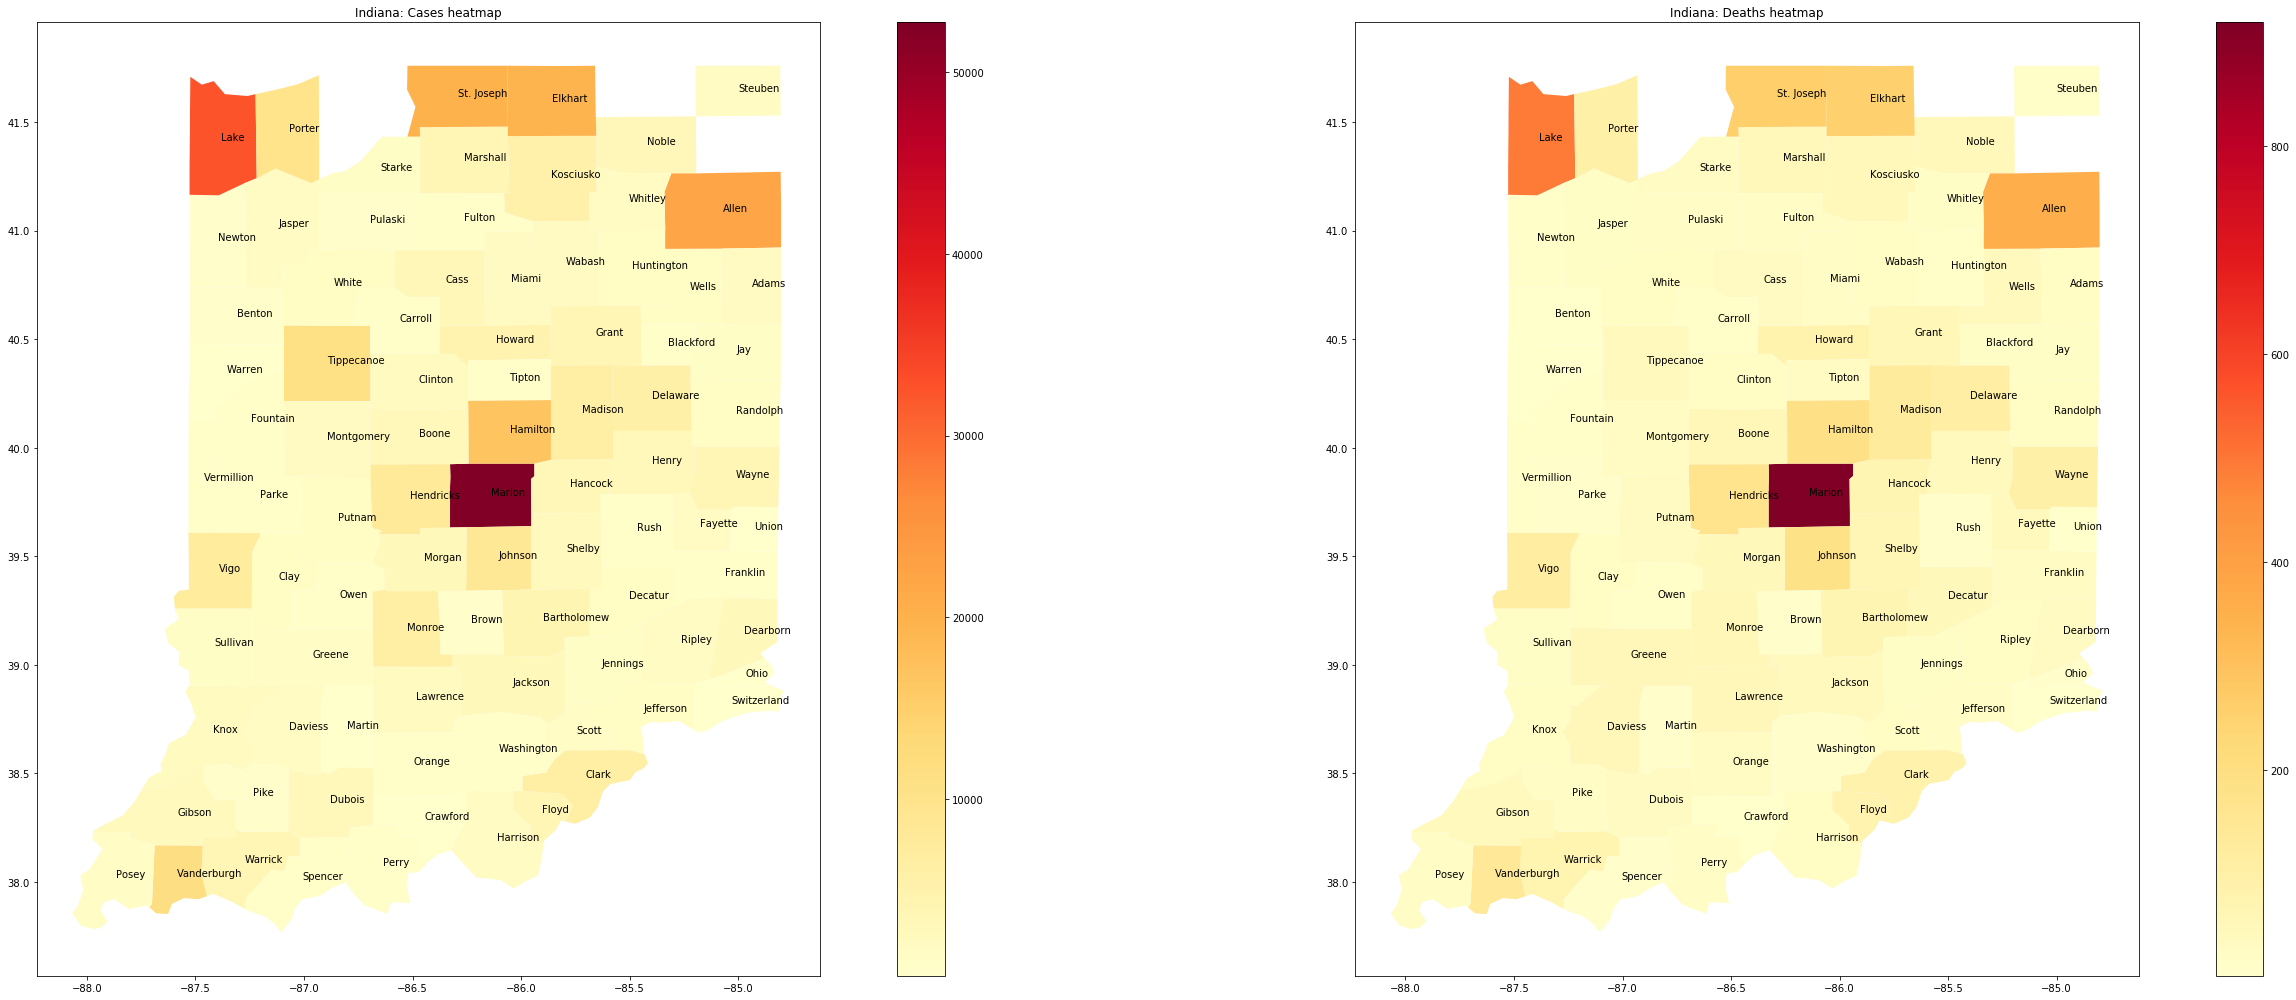

In [24]:
for st in states.keys():
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (40,14))
    plot_map(st, "Cases", axes[0], names=True )
    plot_map(st, "Deaths", axes[1], names = True)
plt.tight_layout()

## Compare with COVID Tracker

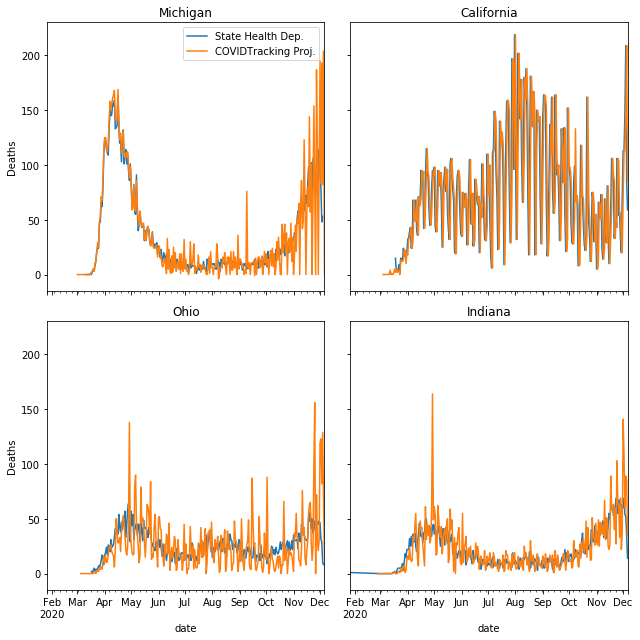

In [25]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, sharex=True, sharey=True, figsize = (9, 9))
for state, st, ax in zip(list(states.keys()), list(states.values()), axes.flatten()):
    byStateDf[ byStateDf["State"] == state].groupby("Date")["Deaths"].sum().plot(ax = ax, label = "State Health Dep.")
    df_tracker[ df_tracker["state"] == st].groupby("date")["deathIncrease"].sum().plot(ax=ax, label = "COVIDTracking Proj.")
    ax.set_title(state)
axes[0][0].legend()
axes[0][0].set_ylabel("Deaths")
axes[1][0].set_ylabel("Deaths")
plt.tight_layout()
# plt.savefig("../report/figs/raw_tracker_comp_nc.pdf")

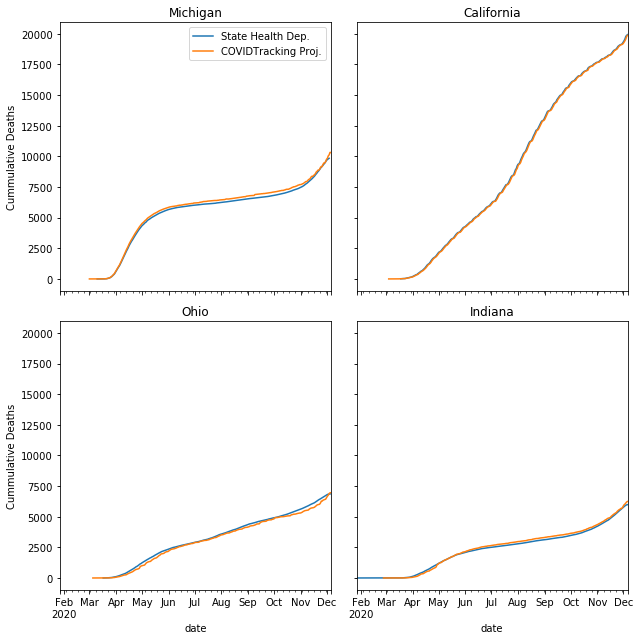

In [26]:
fig, axes = plt.subplots(ncols = 2, nrows=2, sharex=True, sharey=True, figsize = (9, 9))
for state, st, ax in zip(list(states.keys()), list(states.values()), axes.flatten()):
    byStateDf[ byStateDf["State"] == state].groupby("Date")["Deaths"].sum().cumsum().plot(ax = ax, label = "State Health Dep.")
    df_tracker[ df_tracker["state"] == st].groupby("date")["death"].sum().plot(ax=ax, label = "COVIDTracking Proj.")
    ax.set_title(state)
axes[0][0].legend()
axes[0][0].set_ylabel("Cummulative Deaths")
axes[1][0].set_ylabel("Cummulative Deaths")
plt.tight_layout()
# plt.savefig("../report/figs/raw_tracker_comp_cum.pdf")

## Compare Deaths statistics

### Yearly (Ohio)

In [27]:
ohio_covid_deaths = byStateDf[ byStateDf["State"] == "Ohio"]["Deaths"].sum()
print("Total COVID deaths in Ohio:", ohio_covid_deaths)

Total COVID deaths in Ohio: 6867


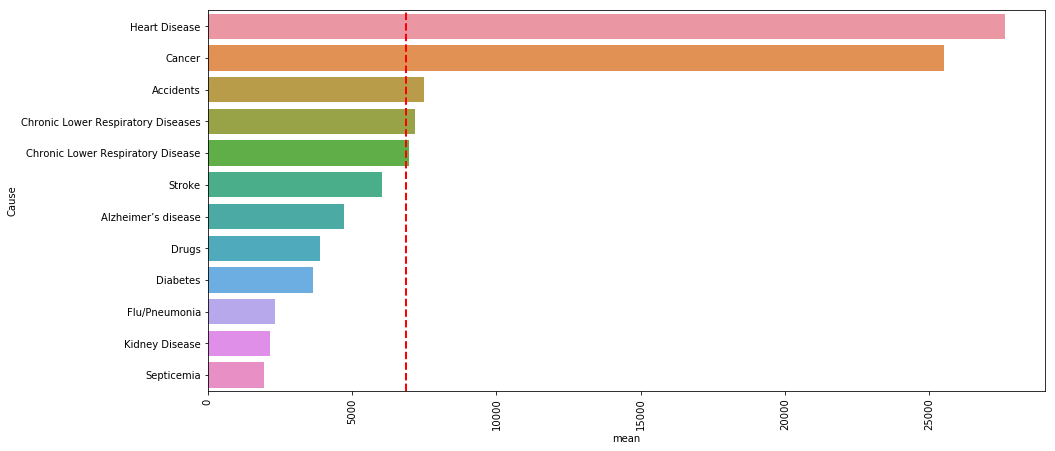

In [28]:
df_ohio_yearly = pd.read_csv('../data/processed/ohio_yearly.csv')
summary = df_ohio_yearly.groupby("Cause")["Deaths"].describe()[["mean","std"]]\
    .sort_values("mean", ascending = False).reset_index()
fig, ax = plt.subplots(1,1,figsize = (15,7))
ax = sns.barplot(data = summary, y="Cause", x="mean")
plt.xticks(rotation = 90)
ax.axvline(x=ohio_covid_deaths,  linewidth = 2, color = 'red', linestyle = '--')
plt.show()

### Weekly statistics

In [30]:
st = "Ohio"
causes = [c for c in excessCdcDeathsDf.columns if "(" in c and not "COVID" in c]
fig = go.Figure()
covid_data = byStateDf[ byStateDf["State"] == st].groupby("WeekNumber")[["Deaths"]].sum().reset_index()
fig.add_trace(go.Scatter( x=covid_data["WeekNumber"], y=covid_data["Deaths"], name = "COVID-19",
                        line = dict(color='black', width=5)))
data = excessCdcDeathsDf[ excessCdcDeathsDf["Jurisdiction of Occurrence"] == st].\
        groupby("WeekNumber")[causes].sum().reset_index()
for c in causes:
    if "R00" in c:
        fig.add_trace(go.Scatter( x=data["WeekNumber"], y=data[c], name = c.split('(')[-1], 
                 line = dict(color='red', width=5)))
    else:
        fig.add_trace(go.Scatter( x=data["WeekNumber"], y=data[c], name = c.split('(')[-1][:-1]))
fig.update_layout(title = st, xaxis_title="Week Number", yaxis_title="Deaths", showlegend = False) 
fig.show()
pd.DataFrame([c[:-1].split('(')[::-1] for c in causes], columns=["IDC", "cause"]).set_index("IDC")

,cause
IDC,
A40-A41,Septicemia
C00-C97,Malignant neoplasms
E10-E14,Diabetes mellitus
G30,Alzheimer disease
J09-J18,Influenza and pneumonia
J40-J47,Chronic lower respiratory diseases
"J00-J06,J30-J39,J67,J70-J98",Other diseases of respiratory system
"N00-N07,N17-N19,N25-N27","Nephritis, nephrotic syndrome and nephrosis"
R00-R99,"Symptoms, signs and abnormal clinical and labo..."


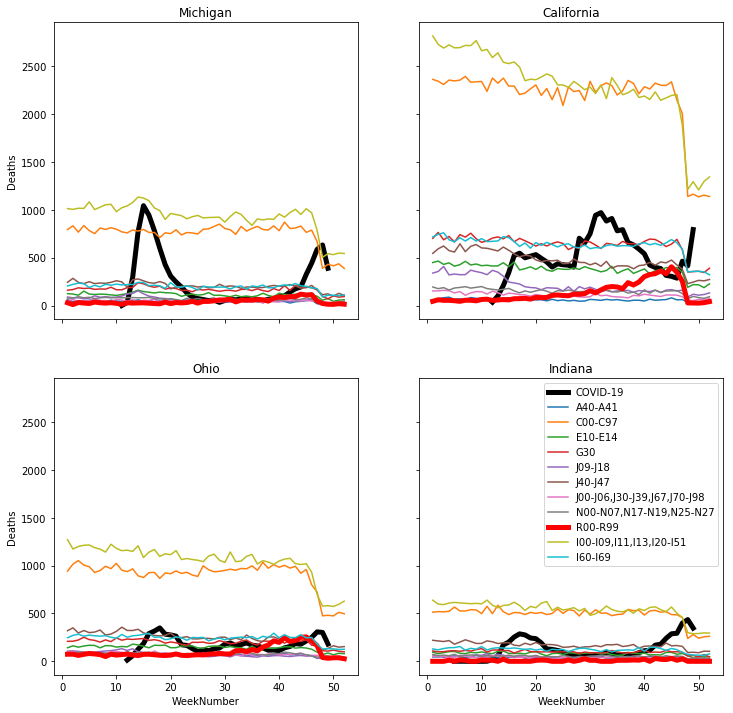

In [31]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, sharex=True, sharey=True, figsize = (12, 12))
for st, ax in zip(states.keys(), axes.flatten()):
    covid_data = byStateDf[ byStateDf["State"] == st].groupby("WeekNumber")[["Deaths"]].sum()
    sns.lineplot(data = covid_data, x="WeekNumber", y="Deaths", linewidth = 5, color='k', label = "COVID-19", ax=ax,
                legend = False)
    data = excessCdcDeathsDf[ excessCdcDeathsDf["Jurisdiction of Occurrence"] == st].\
        groupby("WeekNumber")[causes].sum()
    for cause in causes:
        label = cause.split('(')[-1][:-1]
        if "R00" in label or "abnormal" in label:
            sns.lineplot(data = data, x="WeekNumber", y=cause, label = label, color='r', linewidth = 5, ax=ax, 
                         legend=False)
        else:
            sns.lineplot(data = data, x="WeekNumber", y=cause, label = label, ax=ax, legend = False)
        ax.set_title(st)
axes.flatten()[-1].legend()

In [32]:
data = byStateDf.groupby(["State", "WeekNumber"])["Deaths"].sum().reset_index()
ps.line(data_frame=data, x="WeekNumber", y="Deaths", color = "State")

## Look at population changes

In [ ]:
# from https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html#par_textimage_1873399417
df_population = \
    pd.read_excel("https://www2.census.gov/programs-surveys/popest/tables/2010-2019/state/totals/nst-est2019-01.xlsx")

df_Population = pd.DataFrame(
    index = df_population.iloc[3:59,0].str.replace(".","").str.upper(), 
    columns =list(df_population.iloc[2,3:])
)
df_Population = pd.DataFrame( df_population.iloc[3:59, 3:] )
df_Population = df_Population.set_index(df_population.iloc[3:59,0].str.replace(".","").str.upper())
df_Population = df_Population.rename(columns=df_population.iloc[2,3:].astype(int))
df_Population.index.names = ["Territory"]

In [ ]:
for state in states:
    pop_State = df_Population.loc[state.upper(),:]
    print(state + " population: %d +- %d ( %.2f %%)" % 
        ( pop_State.mean(), pop_State.std(), 100*pop_State.std()/pop_State.mean())
        )


## Testing

In [ ]:
fig, axes = plt.subplots(ncols = 2, nrows=2, sharex=True, sharey=True, figsize = (12, 12))
for state, ax in zip(states.keys(), axes.flatten() ):
    indStateDf = byStateDf[byStateDf["State"] == state]
    for t in ["Tests", "Positive", "Negative"]:
        sns.lineplot(data = indStateDf, x="Date", y=t, label = t, legend = False, ax=ax)
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(state)
    ax.grid()
axes.flatten()[0].legend()
plt.show()